# Trigger efficiency with a skimmer

```
mkdir data/
scp -r cmslpc-sl7.fnal.gov:/eos/uscms/store/user/lpcdihiggsboost/cmantill/PFNano/2017_UL_ak15/GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8/RunIISummer19UL17Jun23-106X_mc2017_realistic_v6-v2/210623_225150/0000/nano_mc2017_1-130.root data/nano_mc2017_1-130.root
```

In [25]:
# or read the file using xrootd
filename = '/store/user/lpcdihiggsboost/cmantill/PFNano/2017_UL_ak15/GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8/RunIISummer19UL17Jun23-106X_mc2017_realistic_v6-v2/210623_225150/0000/nano_mc2017_1-130.root'

Then, we import some libraries:

In [26]:
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval

# we suppress ROOT warnings where our input ROOT tree has duplicate branches - these are handled correctly.
import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")

Define the matching function:

In [27]:
def getParticles(genparticles,lowid=22,highid=25,flags=['fromHardProcess', 'isLastCopy']):
    """
    returns the particle objects that satisfy a low id, 
    high id condition and have certain flags
    """
    absid = abs(genparticles.pdgId)
    return genparticles[
        ((absid >= lowid) & (absid <= highid))
        & genparticles.hasFlags(flags)
    ]

def match_HWWlepqq(genparticles,candidatefj):
    """
    return the number of matched objects (hWW*),daughters, 
    and gen flavor (enuqq, munuqq, taunuqq) 
    """
    W_PDGID = 24
    HIGGS_PDGID = 25
    higgs = getParticles(genparticles,HIGGS_PDGID)
    is_hWW = ak.all(abs(higgs.children.pdgId)==W_PDGID,axis=2)

    higgs = higgs[is_hWW]
    higgs_wstar = higgs.children[ak.argmin(higgs.children.mass,axis=2,keepdims=True)]
    higgs_w = higgs.children[ak.argmax(higgs.children.mass,axis=2,keepdims=True)]
    
    prompt_electron = getParticles(genparticles,11,11,['isPrompt','isLastCopy'])
    prompt_muon = getParticles(genparticles,13,13,['isPrompt', 'isLastCopy'])
    prompt_tau = getParticles(genparticles,15,15,['isPrompt', 'isLastCopy'])
    prompt_q = getParticles(genparticles,0,5,['fromHardProcess', 'isLastCopy'])
    prompt_q = prompt_q[abs(prompt_q.distinctParent.pdgId) == W_PDGID]
    
    dr_fj_quarks = candidatefj.delta_r(prompt_q)
    dr_fj_electrons = candidatefj.delta_r(prompt_electron)
    dr_fj_muons = candidatefj.delta_r(prompt_muon)
    dr_fj_taus = candidatefj.delta_r(prompt_tau)
    dr_daughters = ak.concatenate([dr_fj_quarks,dr_fj_electrons,dr_fj_muons,dr_fj_taus],axis=1)
    hWWlepqq_nprongs = ak.sum(dr_daughters<0.8,axis=1)
    
    n_electrons = ak.sum(prompt_electron.pt>0,axis=1)
    n_muons = ak.sum(prompt_muon.pt>0,axis=1)
    n_taus = ak.sum(prompt_tau.pt>0,axis=1)
    n_quarks = ak.sum(prompt_q.pt>0,axis=1)

    # 4(elenuqq),6(munuqq),8(taunuqq)
    hWWlepqq_flavor = (n_quarks==2)*1 + (n_electrons==1)*3 + (n_muons==1)*5 + (n_taus==1)*7
    
    matchedH = candidatefj.nearest(higgs, axis=1, threshold=0.8)
    matchedW = candidatefj.nearest(higgs_w, axis=1, threshold=0.8)
    matchedWstar = candidatefj.nearest(higgs_wstar, axis=1, threshold=0.8) 

    # 1 (H only), 4(W), 6(W star), 9(H, W and Wstar)
    hWWlepqq_matched = (
        (ak.sum(matchedH.pt > 0, axis=1)==1) * 1 
        + (ak.sum(ak.flatten(matchedW.pt > 0, axis=2), axis=1)==1) * 3 
        + (ak.sum(ak.flatten(matchedWstar.pt > 0, axis=2), axis=1)==1) * 5
    )
    
    # leptons matched
    dr_leptons = ak.concatenate([dr_fj_electrons,dr_fj_muons], axis=1)
    matched_leptons = dr_leptons < 0.8
    
    leptons = ak.concatenate([prompt_electron, prompt_muon], axis=1)
    leptons = leptons[matched_leptons]
    
    # leptons coming from W or W*
    leptons_mass = ak.firsts(leptons.distinctParent.mass)
    higgs_w_mass = ak.firsts(ak.flatten(higgs_w.mass))[ak.firsts(leptons.pt > 0)]
    higgs_wstar_mass = ak.firsts(ak.flatten(higgs_wstar.mass))[ak.firsts(leptons.pt > 0)]

    iswlepton = (leptons_mass == higgs_w_mass)
    iswstarlepton = (leptons_mass == higgs_wstar_mass)
    
    # let's return only:
    # - matchedH (the higgs boson that is matched to the jet)
    # - (iswlepton,iswstarlepton)
    return matchedH,iswlepton,iswstarlepton

Now, let's define a processor:

In [28]:
import numpy as np
import pandas as pd
from coffea.processor import ProcessorABC, column_accumulator
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection
    
class TriggerEfficienciesProcessor(ProcessorABC):
    """ Accumulates histograms from all input events: 1) before triggers, and 2) after triggers """
    def __init__(self, year=2017):
        super(TriggerEfficienciesProcessor, self).__init__()
        self._year = year
        self._trigger_dict = {
            2017:{
                "enominal": [
                    "Ele35_WPTight_Gsf", # electron trigger with isolation
                    "Ele115_CaloIdVT_GsfTrkIdT", # electron trigger without isolation
                ],
                "ejet": [
                    "Ele50_CaloIdVT_GsfTrkIdT_PFJet165"
                ],
                "evvl": [
                    "Ele15_IsoVVVL_PFHT600"
                ],
                "evvlmet": [
                    "Ele15_IsoVVVL_PFHT450_PFMET50"
                ],
                "jet": [
                    "PFHT1050",
                    "AK8PFJet400_TrimMass30",
                    "AK8PFJet420_TrimMass30",
                    "AK8PFHT800_TrimMass50",
                    "PFJet500",
                    "AK8PFJet500",
                ],
                "munominal": [
                    "IsoMu27", # muon trigger with isolation
                    "Mu50", # muon trigger without isolation
                ],
                "muvvlmet": [
                    "Mu15_IsoVVVL_PFHT450_PFMET50"
                ],
                "muvvl": [
                    "Mu15_IsoVVVL_PFHT600"
                ],
            }
        }[self._year]
        self._triggers = {"ele": ["enominal","ejet","evvl","evvlmet","jet"],
                          "mu": ["munominal","muvvl","muvvlmet","jet"],
                          "had": ["jet"],
                         }
        
        self._channels = ["ele","mu"]
    
    def pad_val(
        self, arr: ak.Array, target: int, value: float, axis: int = 0, to_numpy: bool = True
    ):
        """pads awkward array up to `target` index along axis `axis` with value `value`, optionally converts to numpy array"""
        ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=True), value)
        return ret.to_numpy() if to_numpy else ret
    
    def process(self, events):
        """ Returns pre- (den) and post- (num) trigger histograms from input NanoAOD events """
        dataset = events.metadata['dataset']
        n_events = len(events)
        isRealData = not hasattr(events, "genWeight")
        
        def pad_val_nevents(arr: ak.Array):
            """pad values with the length equal to the number of events"""
            return self.pad_val(arr, n_events, -1)
    
        # skimmed events for different channels
        out = {}
        for channel in self._channels:
            out[channel] = {}

        """ Save OR of triggers as booleans """
        for channel in self._channels:
            HLT_triggers = {}
            for t in self._triggers[channel]:
                HLT_triggers["HLT_"+t] = np.any(
                        np.array(
                            [
                                events.HLT[trigger] for trigger in self._trigger_dict[t] if trigger in events.HLT.fields
                            ]
                        ),
                        axis=0,
                )                
            out[channel] = {**out[channel], **HLT_triggers}

        """ Baseline selection """
        goodmuon = (
            (events.Muon.pt > 25)
            & (abs(events.Muon.eta) < 2.4)
            & events.Muon.mediumId
        )
        nmuons = ak.sum(goodmuon, axis=1)
        goodelectron = (
            (events.Electron.pt > 25)
            & (abs(events.Electron.eta) < 2.5)
            & (events.Electron.mvaFall17V2noIso_WP90)
        )
        nelectrons = ak.sum(goodelectron, axis=1)
        goodtau = (
            (events.Tau.pt > 20)
            & (abs(events.Tau.eta) < 2.3)
            & (events.Tau.idAntiEle >= 8)
            & (events.Tau.idAntiMu >= 1)
        )
        ntaus = ak.sum(goodtau, axis=1)
        
        # leading lepton
        goodleptons = ak.concatenate([events.Muon[goodmuon], events.Electron[goodelectron]], axis=1)
        candidatelep = ak.firsts(goodleptons[ak.argsort(goodleptons.pt)])
        
        # fatjet closest to MET
        fatjets = events.FatJet
        candidatefj = fatjets[
            (fatjets.pt > 200) &
            (abs(fatjets.eta) < 2.4)
        ]
        met = events.MET
        dphi_met_fj = abs(candidatefj.delta_phi(met))
        candidatefj = ak.firsts(candidatefj[ak.argmin(dphi_met_fj,axis=1,keepdims=True)])
        dr_lep_fj = candidatefj.delta_r(candidatelep)

        # jets
        jets = events.Jet
        candidatejet = jets[
            (jets.pt > 30) 
            & (abs(jets.eta) < 2.5) 
            & jets.isTight
        ]
        
        # define isolation
        mu_iso = ak.where(candidatelep.pt >= 55., candidatelep.miniPFRelIso_all, candidatelep.pfRelIso03_all)
        ele_iso = ak.where(candidatelep.pt >= 120., candidatelep.pfRelIso03_all, candidatelep.pfRelIso03_all)
        
        # define selections for different channels
        for channel in self._channels:
            selection = PackedSelection()
            selection.add('fjkin', candidatefj.pt > 200)
            if channel=="mu":
                selection.add('onemuon', (nmuons == 1) & (nelectrons == 0) & (ntaus == 0))
                selection.add('muonkin', (candidatelep.pt > 27.) & abs(candidatelep.eta < 2.4))
            elif channel=="ele":
                selection.add('oneelectron', (nelectrons == 1) & (nmuons == 0) & (ntaus == 0))
                selection.add('electronkin', (candidatelep.pt > 30.) & abs(candidatelep.eta < 2.4))

            """ Define other variables to save """
            out[channel]["fj_pt"] = pad_val_nevents(candidatefj.pt)
            out[channel]["fj_msoftdrop"] = pad_val_nevents(candidatefj.msoftdrop)
            out[channel]["lep_pt"] = pad_val_nevents(candidatelep.pt)
            if channel=="mu":
                out[channel]["lep_isolation"] = pad_val_nevents(mu_iso)
            elif channel=="ele":
                out[channel]["lep_isolation"] = pad_val_nevents(ele_iso)
            out[channel]["fj_lep_mass"] = pad_val_nevents((candidatefj - candidatelep).mass)
            out[channel]["fj_lep_dR"] = pad_val_nevents(dr_lep_fj)
            out[channel]["ht"] = pad_val_nevents(ak.sum(candidatejet.pt, axis=1))
            
            if "HToWW" in dataset:
                matchedH,iswlepton,iswstarlepton = match_HWWlepqq(events.GenPart,candidatefj)
                matchedH_pt = ak.firsts(matchedH.pt)
            else:
                matchedH_pt = ak.zeros_like(candidatefj.pt)
                iswlepton = ak.ones_like(candidatefj.pt, dtype=bool)
                iswstarlepton = ak.ones_like(candidatefj.pt, dtype=bool)
            out[channel]["higgspt"] = pad_val_nevents(matchedH_pt)
            out[channel]["iswlepton"] = pad_val_nevents(iswlepton)
            out[channel]["iswstarlepton"] = pad_val_nevents(iswstarlepton)

            # use column accumulators
            out[channel] = {
                key: column_accumulator(value[selection.all(*selection.names)])
                for (key, value) in out[channel].items()
            }
        
        return {
            self._year: {
                dataset: {"nevents": n_events, "skimmed_events": out}
            }
        }

                  
    def postprocess(self, accumulator):
        for year, datasets in accumulator.items():
            for dataset, output in datasets.items():
                for channel in output["skimmed_events"].keys():
                    output["skimmed_events"][channel] = {
                        key: value.value for (key, value) in output["skimmed_events"][channel].items()
                    }
                
        return accumulator

In [29]:
import uproot
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema

from coffea.processor import IterativeExecutor,Runner,DaskExecutor

# define fileset
# fileset = {"HToWW": ["data/nano_mc2017_1-130.root"]}    ### if you have the file locally
fileset = {"HToWW": ["root://xcache/"+ filename]}         ### if you read it through xrootd

# define processor
# here you can change "triggers" to have more options: e.g. nominal,jet ...
p = TriggerEfficienciesProcessor(year=2017)

# define iterative executor (to run locally)
executor = IterativeExecutor(compression=1, status=True, workers=1)

# define the runner (with NanoAODSchema)
run = Runner(executor=executor,savemetrics=True,chunksize=10000,schema=NanoAODSchema)

# run 
out,metrics = run(fileset,'Events',processor_instance=p)

Processing:   0%|          | 0/7 [00:00<?, ?chunk/s]

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:207: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:207: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


In [30]:
out

{2017: {'HToWW': {'nevents': 66800,
   'skimmed_events': {'ele': {'lep_isolation': array([7.17474446e-02, 1.03485018e-01, 6.78050935e-01, 4.10955921e-02,
            4.21260625e-01, 1.19895065e+00, 7.06366241e-01, 1.61444843e-01,
            3.98819983e-01, 1.51438713e-02, 0.00000000e+00, 2.04060487e-02,
            5.41986665e-03, 6.92830794e-03, 0.00000000e+00, 1.38603617e-02,
            1.91521775e-02, 1.85417267e-03, 0.00000000e+00, 2.36793920e-01,
            1.16677034e+00, 8.29970557e-03, 2.85538107e-01, 2.61875540e-01,
            0.00000000e+00, 1.00740287e-02, 2.73448706e-01, 0.00000000e+00,
            2.59080734e-02, 6.75398856e-03, 5.89381121e-02, 1.03086457e-01,
            1.21556194e-02, 4.23152670e-02, 1.22235045e-02, 8.93559679e-03,
            0.00000000e+00, 3.88218433e-01, 2.30432361e-01, 0.00000000e+00,
            0.00000000e+00, 7.49507267e-03, 1.44381061e-01, 1.03136614e-01,
            0.00000000e+00, 1.11079286e-03, 0.00000000e+00, 0.00000000e+00,
          

In [31]:
out[2017]["HToWW"]["skimmed_events"]["ele"].keys()

dict_keys(['lep_isolation', 'lep_pt', 'HLT_evvlmet', 'HLT_jet', 'ht', 'iswstarlepton', 'HLT_evvl', 'HLT_ejet', 'fj_pt', 'fj_lep_mass', 'iswlepton', 'fj_lep_dR', 'fj_msoftdrop', 'HLT_enominal', 'higgspt'])

In [32]:
out[2017]["HToWW"]["skimmed_events"]["ele"]["fj_pt"][out[2017]["HToWW"]["skimmed_events"]["ele"]["fj_pt"] >0]

array([215.75 , 291.5  , 224.   , 257.75 , 276.   , 382.75 , 209.5  ,
       290.5  , 234.5  , 270.   , 261.   , 203.375, 204.   , 226.75 ,
       240.25 , 239.75 , 230.875, 213.125, 266.25 , 351.5  , 394.   ,
       217.75 , 250.625, 290.5  , 223.625, 333.25 , 273.75 , 383.25 ,
       346.5  , 245.   , 215.875, 233.   , 323.   , 221.375, 263.25 ,
       368.25 , 215.   , 207.375, 327.5  , 261.25 , 215.125, 246.   ,
       219.375, 265.75 , 243.875, 249.625, 342.5  , 245.375, 388.   ,
       206.125, 289.75 , 208.   , 378.75 , 265.   , 282.   , 205.5  ,
       228.75 , 218.625, 215.375, 251.5  , 230.125, 264.   , 201.875,
       297.   , 240.875, 228.875, 219.625, 210.   , 274.   , 210.375,
       220.125, 248.875, 270.25 , 233.5  , 274.   , 225.   , 249.125,
       318.   , 213.75 , 258.75 , 212.75 , 223.75 , 266.25 , 208.875,
       201.75 , 240.   , 235.875, 233.   , 252.25 , 465.25 , 225.75 ,
       269.   , 201.375, 223.25 , 264.5  , 256.75 , 202.125, 248.875,
       221.375, 200.

/tmp/ipykernel_886/4140971210.py:39: RuntimeWarning: invalid value encountered in true_divide
  return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())


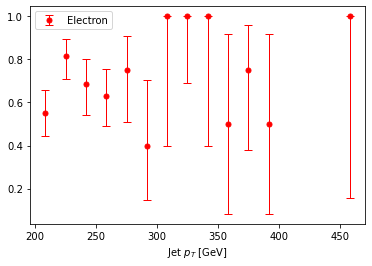

In [33]:
# now we can make a histogram
import hist as hist2
jetpt_axis = hist2.axis.Regular(30, 200, 700, name='jetpt', label=r'Jet $p_T$ [GeV]')
leppt_axis = hist2.axis.Regular(30, 10, 200, name='leppt', label=r'Lepton $p_T$ [GeV]')
hpt_axis = hist2.axis.Regular(50, 10, 800, name='higgspt', label=r'matched H $p_T$ [GeV]')
region_cat = hist2.axis.StrCategory(["numerator","denominator"], name="region")
channel_cat = hist2.axis.StrCategory([], name='channel', growth=True)
ht_axis = hist2.axis.Regular(20,180,2000, name='ht', label=r'HT [GeV]')


hists = {}
hists["jet"] = hist2.Hist(
                channel_cat,
                region_cat,
                jetpt_axis,
            )
# now we can fill the histogram with the denominator (baseline selection already applied)
jetpt = out[2017]["HToWW"]["skimmed_events"]["ele"]["fj_pt"]
trigger_selection = out[2017]["HToWW"]["skimmed_events"]["ele"]["HLT_enominal"]
hists["jet"].fill(
    channel="ele",
    region="denominator",
    jetpt=jetpt
)
hists["jet"].fill(
    channel="ele",
    region="numerator",
    jetpt=jetpt[trigger_selection]
)

# now we plot
num = hists["jet"][{"region":"numerator","channel":"ele"}]
den = hists["jet"][{"region":"denominator","channel":"ele"}]

import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval
def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

fig, ax = plt.subplots(1, 1)
hep.histplot(num/den, 
             yerr=get_yerr(num,den),
             ax = ax,
             histtype='errorbar', color='red', capsize=4, elinewidth=1, label="Electron",         
)
ax.legend()